# **Phase 1 - Milestone 2**

**Ediashta Revindra Amirussalam**

FTDS - RMT - 020

## Objective

## 00 - Import Libraries

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss

## 01 - Data Loading

In [44]:
#load data
data  = pd.read_csv('./laptops.csv')

In [45]:
#check head
data.head()

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01


In [46]:
data_copy = data.copy()

## 02 - EDA

In [47]:
#check data basic info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2160 entries, 0 to 2159
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Laptop        2160 non-null   object 
 1   Status        2160 non-null   object 
 2   Brand         2160 non-null   object 
 3   Model         2160 non-null   object 
 4   CPU           2160 non-null   object 
 5   RAM           2160 non-null   int64  
 6   Storage       2160 non-null   int64  
 7   Storage type  2118 non-null   object 
 8   GPU           789 non-null    object 
 9   Screen        2156 non-null   float64
 10  Touch         2160 non-null   object 
 11  Final Price   2160 non-null   float64
dtypes: float64(2), int64(2), object(8)
memory usage: 202.6+ KB


In [48]:
#check data basic statistics
data.describe()

,RAM,Storage,Screen,Final Price
count,2160.000000,2160.000000,2156.000000,2160.000000
mean,15.413889,596.294444,15.168112,1312.638509
std,9.867815,361.220506,1.203329,911.475417
min,4.000000,0.000000,10.100000,201.050000
25%,8.000000,256.000000,14.000000,661.082500
50%,16.000000,512.000000,15.600000,1031.945000
75%,16.000000,1000.000000,15.600000,1708.970000
max,128.000000,4000.000000,18.000000,7150.470000


<Axes: xlabel='count', ylabel='Brand'>

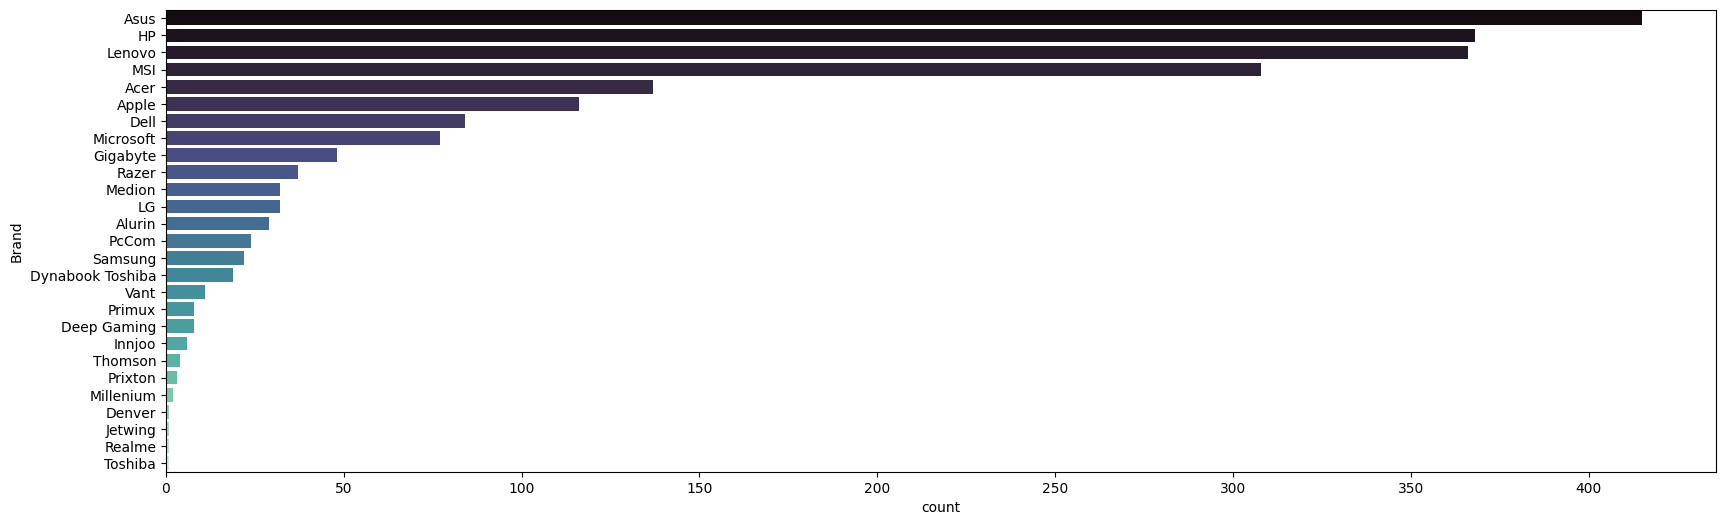

In [49]:
#check laptop specs
plt.figure(figsize=(20,6))
sns.countplot(data=data, y="Brand", order = data["Brand"].value_counts().index, palette="mako")

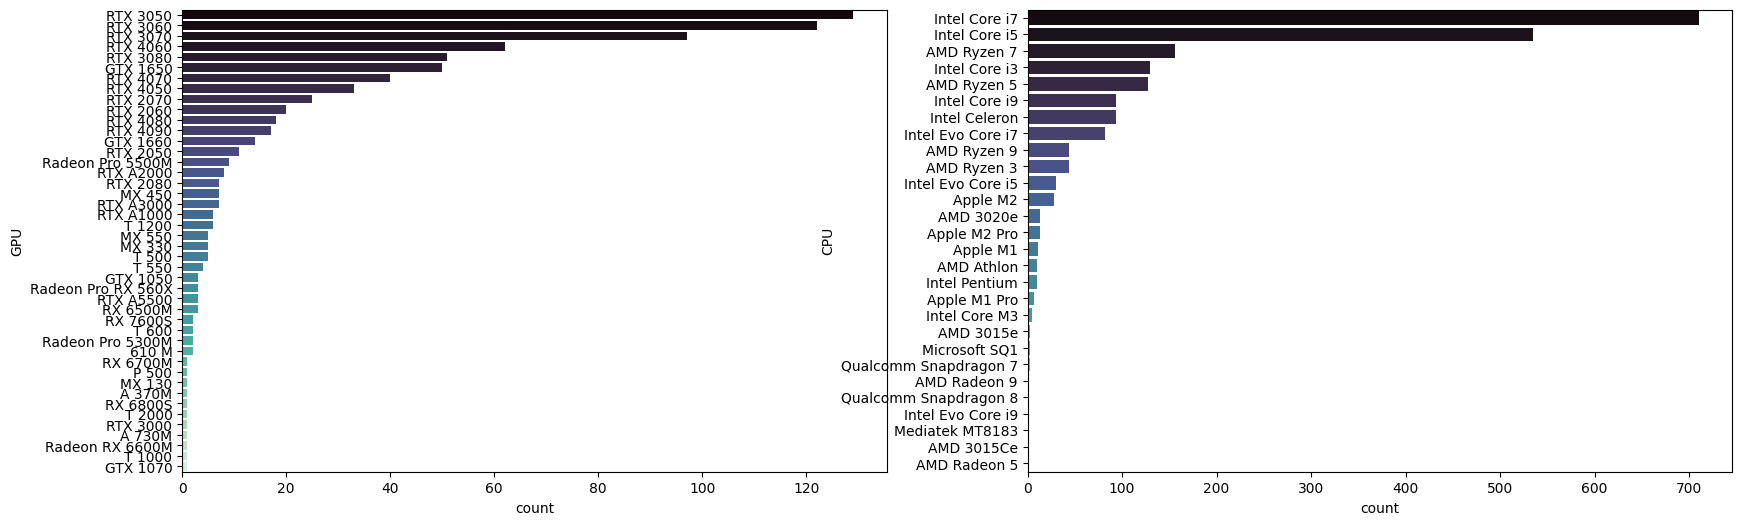

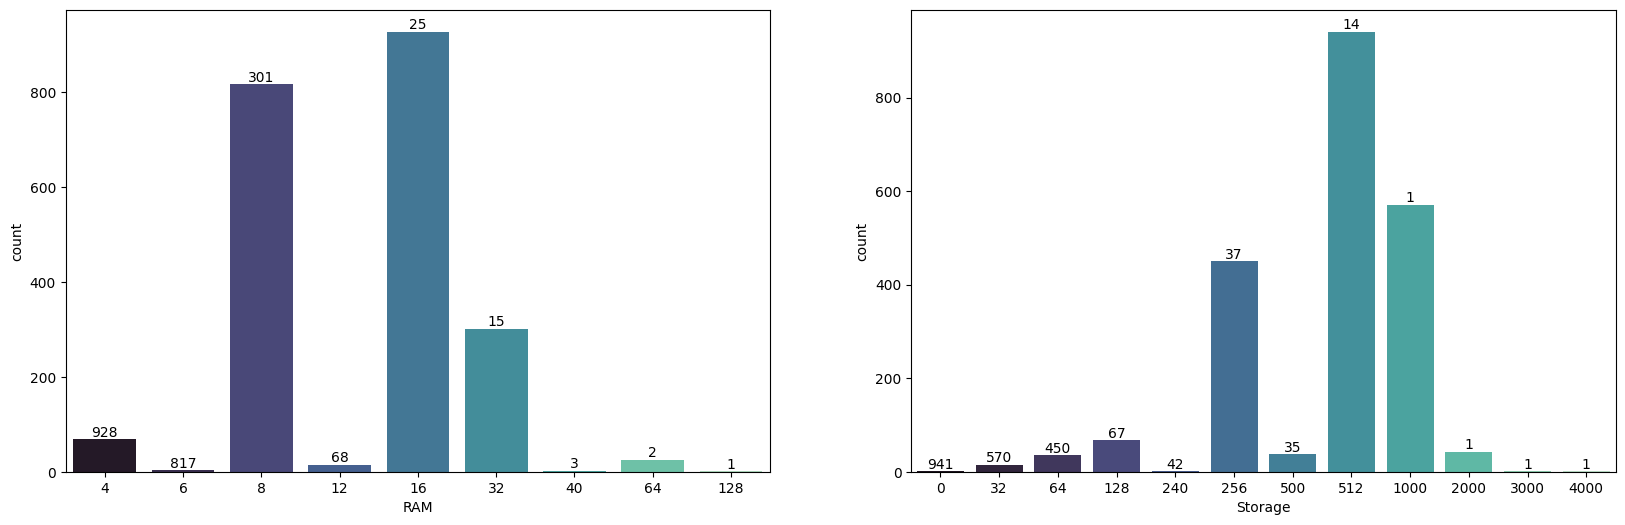

In [147]:
#check laptop specs
plt.figure(figsize=(20,6))

plt.subplot(1,2,1)
sns.countplot(data=data, y="GPU", order = data["GPU"].value_counts().index, palette="mako")

plt.subplot(1,2,2)
sns.countplot(data=data, y="CPU", order = data["CPU"].value_counts().index, palette="mako")

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
ax1 = sns.countplot(data=data, x="RAM", palette="mako")
ax1.bar_label(container=ax1.containers[0], labels=data["RAM"].value_counts().values)

plt.subplot(1,2,2)
ax2 = sns.countplot(data=data, x="Storage", palette="mako")
ax2.bar_label(container=ax2.containers[0], labels=data["Storage"].value_counts().values)

plt.show()

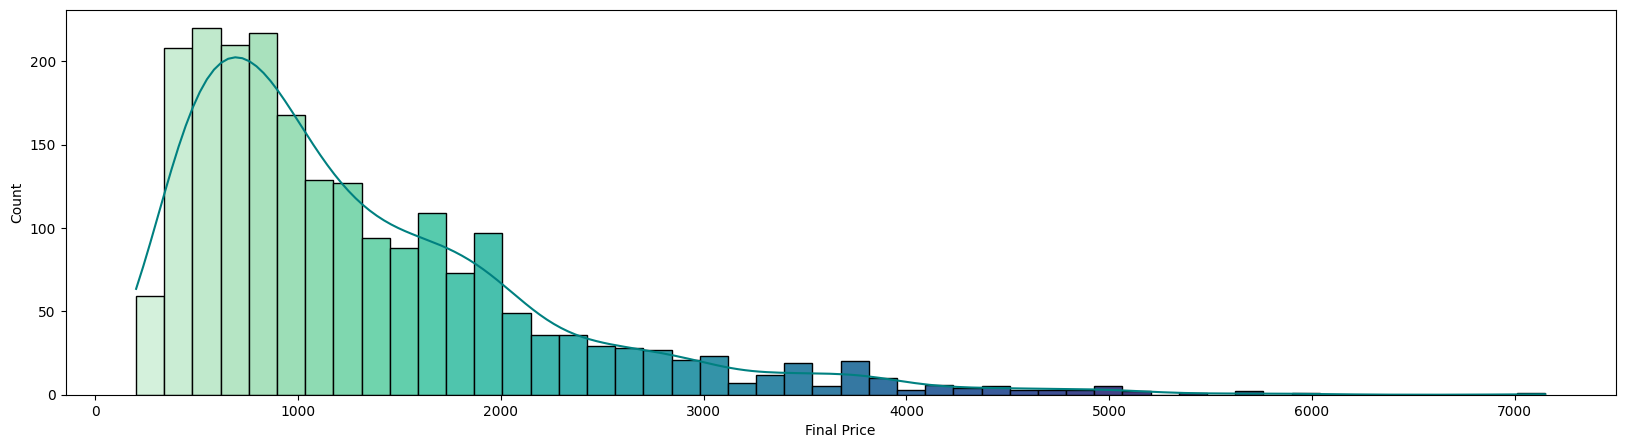

In [51]:
#check price distribution
plt.figure(figsize=(20,5))

palette = sns.color_palette("mako_r",50)

plot = sns.histplot(data=data, x="Final Price", kde=True, bins=50, color="teal")

for bin_,i in zip(plot.patches,palette):
    bin_.set_facecolor(i)
    
plt.show()

In [133]:
#handle screen cardinality
screen = pd.DataFrame(data["Screen"].value_counts().rename_axis('screen').reset_index(name='counts'))
sum = screen["counts"].sum()

for i in screen[(screen["counts"]/sum) < 0.05]["screen"]:
     screen.loc[screen["screen"] == i, "screen"] = "Other"
     
screen_new = screen.groupby(screen['screen']).aggregate({'screen': 'first', 'counts': 'sum'})

storage_type = pd.DataFrame(data["Storage type"].value_counts().rename_axis('storage_type').reset_index(name='counts'))
touch_type = pd.DataFrame(data["Touch"].value_counts().rename_axis('touch').reset_index(name='counts'))

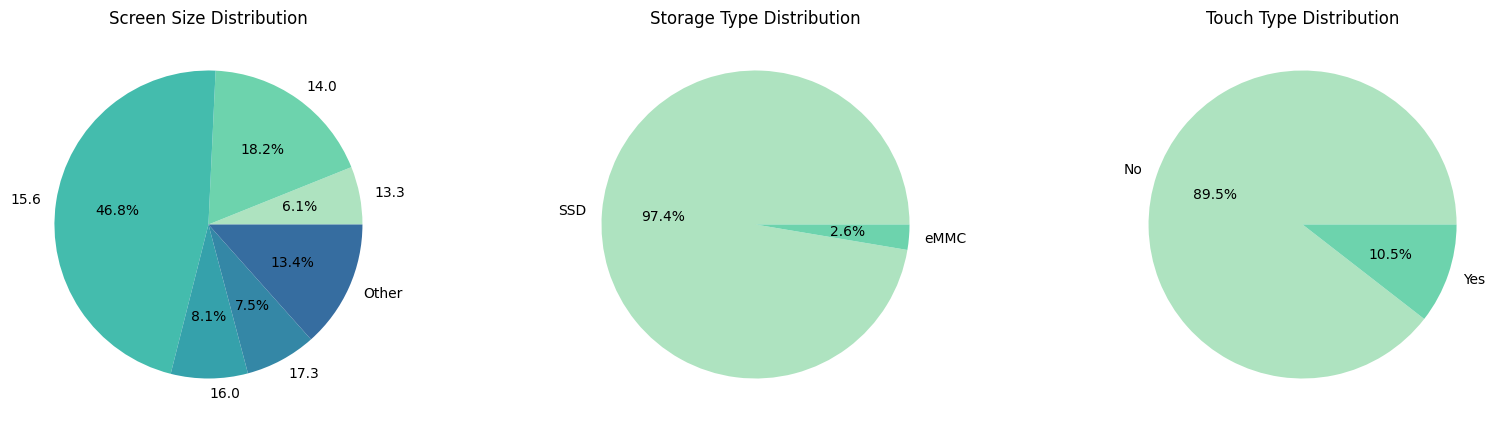

In [143]:
plt.figure(figsize=(20,5))

palette = sns.color_palette("mako_r",10)

plt.subplot(1,3,1)
plt.pie(screen_new["counts"], labels=screen_new["screen"], autopct='%1.1f%%', colors=palette)
plt.title("Screen Size Distribution")

plt.subplot(1,3,2)
plt.pie(storage_type["counts"], labels=storage_type["storage_type"], autopct='%1.1f%%', colors=palette)
plt.title("Storage Type Distribution")

plt.subplot(1,3,3)
plt.pie(touch_type["counts"], labels=touch_type["touch"], autopct='%1.1f%%', colors=palette)
plt.title("Touch Type Distribution")

plt.show()

In [155]:
#def cramers_v
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [156]:
data

,Laptop,Status,Brand,Model,CPU,RAM,Storage,Storage type,GPU,Screen,Touch,Final Price
0,ASUS ExpertBook B1 B1502CBA-EJ0436X Intel Core...,New,Asus,ExpertBook,Intel Core i5,8,512,SSD,NaN,15.6,No,1009.00
1,Alurin Go Start Intel Celeron N4020/8GB/256GB ...,New,Alurin,Go,Intel Celeron,8,256,SSD,NaN,15.6,No,299.00
2,ASUS ExpertBook B1 B1502CBA-EJ0424X Intel Core...,New,Asus,ExpertBook,Intel Core i3,8,256,SSD,NaN,15.6,No,789.00
3,MSI Katana GF66 12UC-082XES Intel Core i7-1270...,New,MSI,Katana,Intel Core i7,16,1000,SSD,RTX 3050,15.6,No,1199.00
4,HP 15S-FQ5085NS Intel Core i5-1235U/16GB/512GB...,New,HP,15S,Intel Core i5,16,512,SSD,NaN,15.6,No,669.01
...,...,...,...,...,...,...,...,...,...,...,...,...
2155,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3060,17.3,No,2699.99
2156,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,16,1000,SSD,RTX 3070,17.3,No,2899.99
2157,Razer Blade 17 FHD 360Hz Intel Core i7-11800H/...,Refurbished,Razer,Blade,Intel Core i7,32,1000,SSD,RTX 3080,17.3,No,3399.99
2158,Razer Book 13 Intel Evo Core i7-1165G7/16GB/1T...,Refurbished,Razer,Book,Intel Evo Core i7,16,1000,SSD,NaN,13.4,Yes,1899.99


Correlation
Status : 0.26450718170008297
Brand : 0.241996453068071
Model : 0.2519900783873629
CPU : 0.2517567086906365
GPU : 0.3422702941182396
Touch : 0.095355125133349


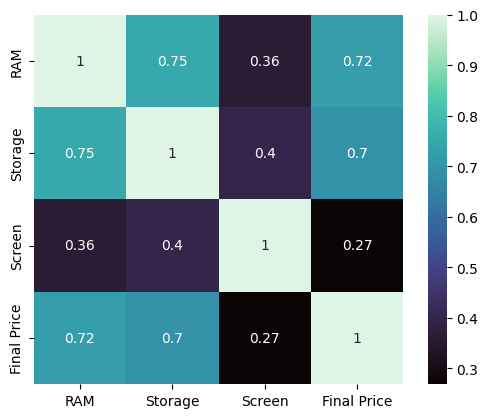

In [160]:
#check correlation plot

#correlation for numerical
corr_matrix = data[["RAM", "Storage", "Screen", "Final Price"]].corr(method="pearson")
sns.heatmap(corr_matrix, annot=True, cmap='mako', square=True)

#correlation for
print("Correlation")
print("Status :",cramers_v(data["Status"], data["Final Price"]))
print("Brand :",cramers_v(data["Brand"], data["Final Price"]))
print("Model :",cramers_v(data["Model"], data["Final Price"]))
print("CPU :",cramers_v(data["CPU"], data["Final Price"]))
print("GPU :",cramers_v(data["GPU"], data["Final Price"]))
print("Touch :",cramers_v(data["Touch"], data["Final Price"]))